# Pipeline v3

In [1]:
import cv2
import glob
import numpy as np
import os
import pandas as pd
import pickle
import time
import trackpy as tp
from importlib import reload
from matplotlib import pyplot as plt
import seaborn as sns
from skimage import io
from skimage import exposure
from skimage.color import label2rgb

#imports from py files
from utils import create_folders
from utils import split_stack
from feature_extraction import apply_feature_extraction
from instance_segmentation import apply_instance_segmentation
from semantic_segmentation import apply_semantic_segmentation

## Set up data structure and load data
First set a `project_path`, this is where the whole project will be stored. The function `create_folders` will then create all necessary subfolders.

In [2]:
project_path = "/home/lhinder/myscratch/test_env/" #Absolute path where this project is stored. End path with "/".
folders = ["stacks_raw","classifier","stacks_segmented","stacks_labeled","stacks_labeled_rings","table_untracked","table_tracked","movies","tmp"]
create_folders(project_path,folders) #Create new folders if they don't already exist

Directory /home/lhinder/myscratch/test_env/stacks_raw already exists
Directory /home/lhinder/myscratch/test_env/classifier already exists
Directory /home/lhinder/myscratch/test_env/stacks_segmented already exists
Directory /home/lhinder/myscratch/test_env/stacks_labeled already exists
Directory /home/lhinder/myscratch/test_env/stacks_labeled_rings already exists
Directory /home/lhinder/myscratch/test_env/table_untracked already exists
Directory /home/lhinder/myscratch/test_env/table_tracked already exists
Directory /home/lhinder/myscratch/test_env/movies already exists
Directory /home/lhinder/myscratch/test_env/tmp already exists


You can now copy the raw tiff files into the subfolder `/stacks_raw`, and a trained classifier into `/classifier` Then run the cell below to load them.

In [3]:
classifier_name = "RF_trained_on_segmenting_cells.sav" # Name of classifier that will be loaded. To train a new clf, use the other notebook.
tmp_path = project_path+"tmp/" #where temporary files are stored
tiff_path = project_path + "stacks_raw/"
tiff_file_paths = (glob.glob(tiff_path + "*.tif*"))
tiff_file_paths.sort()
tiff_file_names = [os.path.basename(name) for name in tiff_file_paths]
classifier = pickle.load(open(project_path+"classifier/"+classifier_name,'rb'))
print("Found {nb_files} tiff file(s): {names}".format(nb_files=len(tiff_file_names),names = tiff_file_names))
if classifier:
    print(f"Loaded the classifier \"{classifier_name}\" of type {type(classifier)}")

Found 1 tiff file(s): ['series_1_Original.tif']
Loaded the classifier "RF_trained_on_segmenting_cells.sav" of type <class 'sklearn.ensemble._forest.RandomForestClassifier'>


## Define variables
Set all the variables for the pipeline. If you use multiple CPUs (recomended), be sure to run the notebook server in a slurm session with the flag `--cpus-per-task` (not `--ntasks`), and provide enough memory.

Example code: 
`salloc --mem 200GB -w izbdelhi --time 24:00:00 --cpus-per-task=50`

For the parameters `min_size` and `max_size`: These are the expected sizes of the nuclei. Note: All nuclei get returned, even if they are outside of this margin. The algorithm just tries to split up nuclei larger than `max_size` and gives up once they are smaller than `min_size`.

The parameter `memory` is to use with caution, as many linking errors can arise once if `memory > 0`.

In [4]:
# Define variables
min_size = 450  # minimum expected pixel area of nucleus (won't try to split further) 
max_size = 1500 # maximum expected pixel area of nucleus (will try to declump)
memory = 0 # max number of frames that a nucleus can disappear and still be assigned the same ID
search_range = 10 # the maximum distance nuclei can move between frames
nb_cores = 50 # number of CPU cores. # use the --cpus-per-task flag in slurm, NOT --ntasks to alow multiple cores

ring_expansion = 10 # how far should the cytosolic ring be expanded (margin will be subtracted)
ring_margin = 3 # margin subtracted from ring to nucleus
# nucleus_margin = 2 # margin subtracted from nucleus #not implemented

## Run the pipeline
The cell below runs the pipeline on all tiff-files stored in `tiff_file_paths`.

Intermediate results are stored in their respective subfolders. To avoid memory leaks in multiprocessing, the stacks are split up into chunks with the `split_stack` function which are then dumped into the `/tmp` subfolder. Each of the subtasks then reads in just one of the chunks, meaning the large stack files don't get multiplied unnecessarily across processes.

### Pandas df where results are stored
- `x` and `y`: position of detected particles
- `size`: nb pixels belonging to nucleus
- `frame`: timestep of timelapse movie
- `mean_nuc_c1` / `_c2` and `mean_ring_c1` / `_c2`: mean pixel intensities of extracted nuclei and cytosolic rings. Used to calculate ratios. `c1` and `c2` stand for the channel numbers.
- `ratio_c1 / c2` the  ratio of `mean_nuc` over `mean_ring`
- `particle`: collumn gets added by trackpy and is the global particla label assigned by trackpy. Continuous between frames.
- `label_frame`: the label initially given after a first segmentation. not continuous between frames!
- `p_nucleus`: mean confidence of all pixels belonging to the nucleus

In [5]:
def apply_pipeline(classifier, stack_path, max_size, min_size, memory):

    ## LOAD IN DATA
    fname = os.path.basename(stack_path) #extract the filename
    stack_raw = io.imread(stack_path)
    stack_raw = stack_raw[:50,:,:,:].copy() #only run the first 50 frames
    tmp_path = project_path+"tmp/" #where temporary files are stored
    
    ## APPLY SEMANTIC SEGMENTATION
    stack_raw = stack_raw[:,:,:,0].copy()
    chunks = split_stack(stack_raw,tmp_path,nb_cores) #split into chunks
    stack_segmented = apply_semantic_segmentation(chunks, classifier) #segment the chunks    
    segmented_stack_path = project_path+"stacks_segmented/"+fname
    io.imsave(segmented_stack_path,stack_segmented) #save stack_segmented
    stack_raw = [] # delete stack_raw from memory
        
        
    ## APPLY INSTANCE SEGMENTATION  
    print("Starting instance segmentation.")
    chunks = split_stack(stack_segmented,tmp_path,nb_cores)
    stack_labeled = apply_instance_segmentation(chunks, min_size, max_size)
    stack_labeled_path = project_path+"stacks_labeled/"+fname
    io.imsave(stack_labeled_path,stack_labeled)
      
    
    ## APPLY RING EXTENSION, CALCULATE RATIOS AND CENTER OF MASS
    stack_raw = io.imread(stack_path)
    stack_raw = stack_raw[:50,:,:,:].copy()
    #stack_segmented = io.imread(segmented_stack_path)
    #stack_labeled = io.imread(stack_labeled_path)
    
    table_untracked, stack_labeled_rings = apply_feature_extraction(stack_labeled,stack_raw,stack_segmented)
    
    #save table_untracked and stack_labeled and stack_labeled_rings
    io.imsave(project_path+"stacks_labeled_rings/"+fname,stack_labeled_rings)
    table_untracked.to_pickle(project_path+"table_untracked/"+fname+".pkl")
    
    stack_raw = []       # delete stack_raw from memory
    stack_segmented = [] # delete stack_segmented from memory
    stack_labeled = []   # delete stack_labeled from memory
    
    
    ## APPLY TRACKING
    table_tracked = tp.link_df(table_untracked, search_range= search_range, memory=memory)
    table_tracked = table_tracked.astype({'particle':'int32'}) #decrease precision
    table_tracked.to_pickle(project_path+"table_tracked/"+fname+".pkl")
    
    table_untracked = [] # delete table_untracked from memory
    table_tracked = []   # delete table_tracked from memory
    
    ## CLEANUP
    # delete temp files
    tmp_files = glob.glob(tmp_path+'*')
    for f in tmp_files:
        os.remove(f)
    print(f"Removed {len(tmp_files)} temporary files.")
    
#run pipeline for multiple files:
stacks = tiff_file_paths
print(f'Run the pipeline on the following tiff files: {tiff_file_names}')
time_start = time.time()

for stack_path in stacks:
    apply_pipeline(classifier, stack_path, max_size, min_size, memory)
    
time_stop = time.time()
time_total =  time_stop - time_start
print("Done. Processing time : "+str(round(time_total/60,2))+" minutes.")

Frame 49: 368 trajectories present.
Removed 50 temporary files.
Done. Processing time : 6.83 minutes.


## Check the results
Below are some plots to check the quality of the results. Select a `file_nb` and `frame_nb`.

In [41]:
## LOAD THE DATA
frame_nb = 20
file_nb = 0

test_file = tiff_file_paths[file_nb]
test_file_name = os.path.basename(test_file)

test_stack_raw = io.imread(project_path+"stacks_raw/"+test_file_name)
f_raw = test_stack_raw[frame_nb,:,:,0].copy() #select nuclear channel
f_raw_c1 = test_stack_raw[frame_nb,:,:,1].copy()
f_raw_c2 = test_stack_raw[frame_nb,:,:,2].copy()
test_stack_raw = []

test_stack_segmented = io.imread(project_path+"stacks_segmented/"+test_file_name)
f_segmented = test_stack_segmented[frame_nb,:,:].copy()
test_stack_segmented = []

test_stack_labeled = io.imread(project_path+"stacks_labeled/"+test_file_name)
f_labeled = test_stack_labeled[frame_nb,:,:].copy()
test_stack_labeled = []

test_stack_labeled_rings = io.imread(project_path+"stacks_labeled_rings/"+test_file_name)
f_labeled_rings = test_stack_labeled_rings[frame_nb,:,:].copy()
test_stack_labeled_rings = []

table_tracked = pd.read_pickle(project_path+"table_tracked/"+test_file_name+".pkl")


img_adapteq = exposure.equalize_adapthist(f_raw, clip_limit=0.03)
f_raw_scaled = img_adapteq#*255
f_raw_scaled= f_raw_scaled#.astype(int)

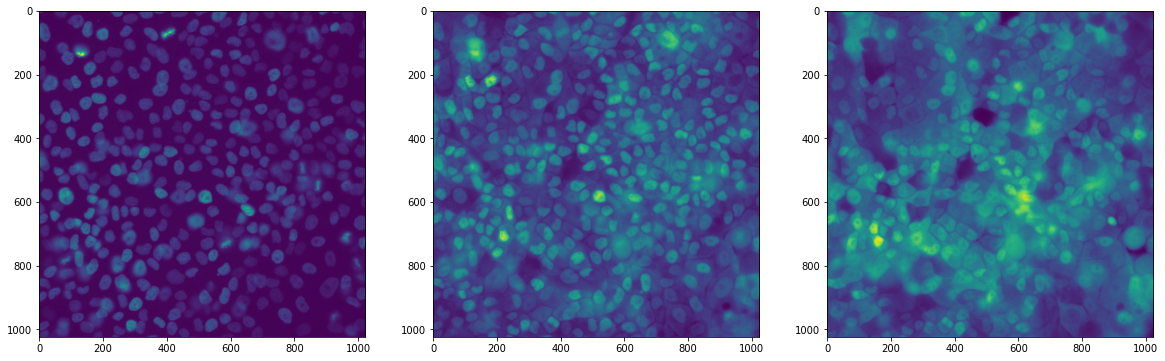

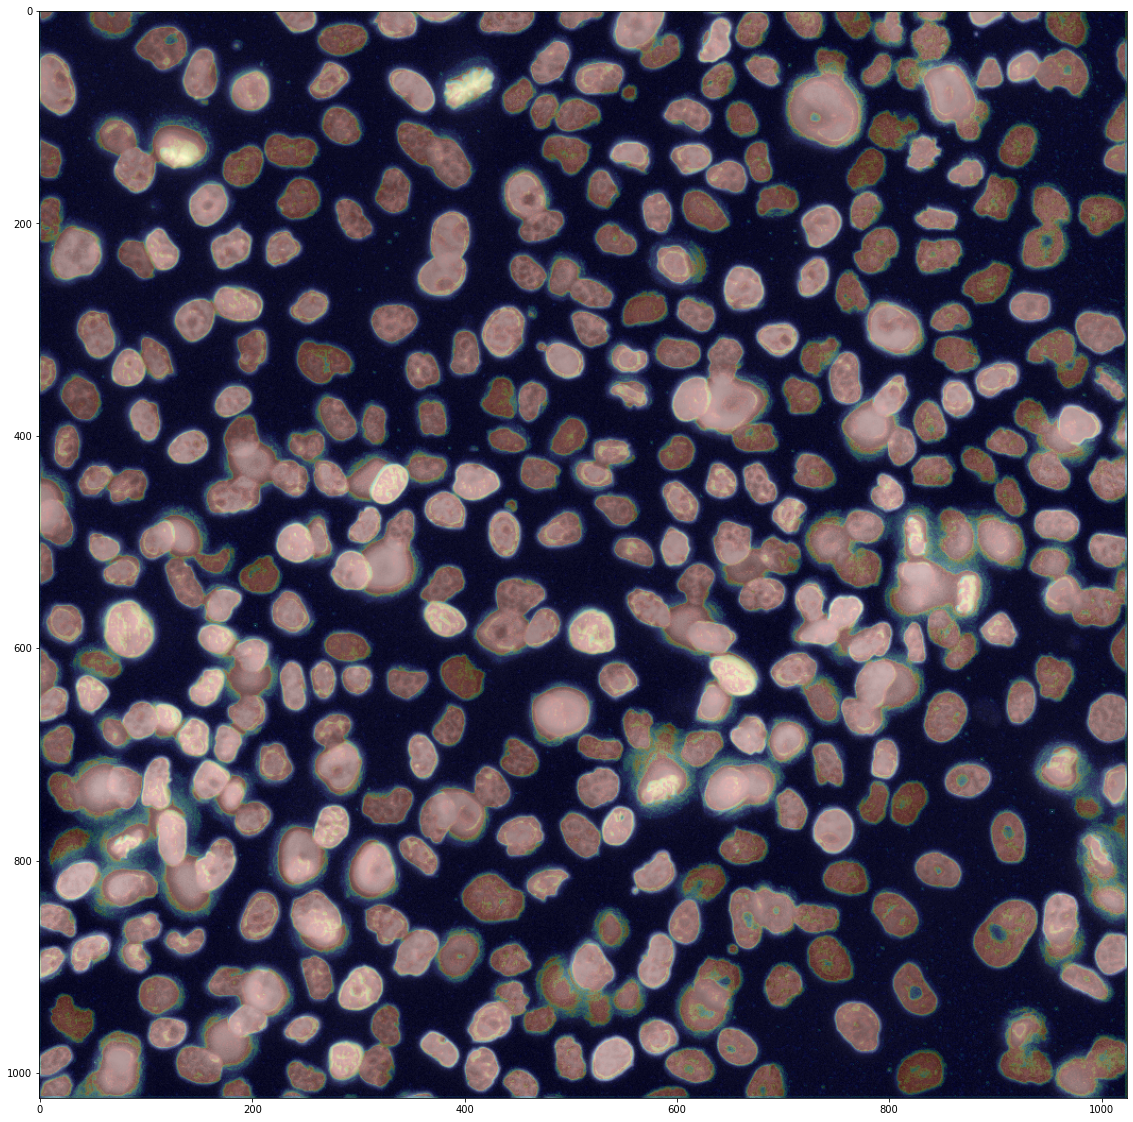

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

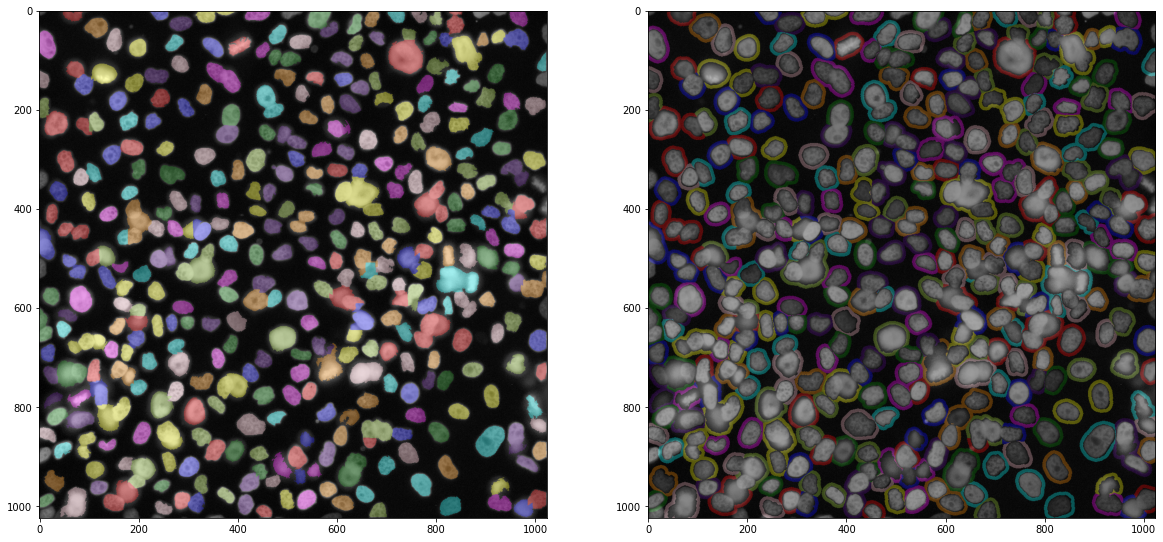

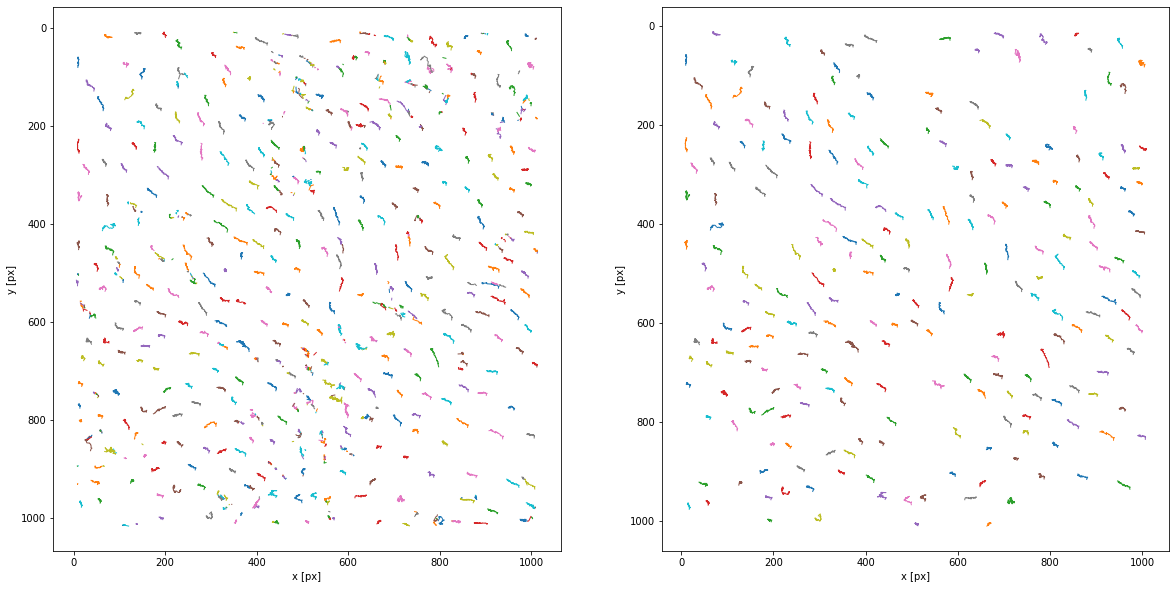

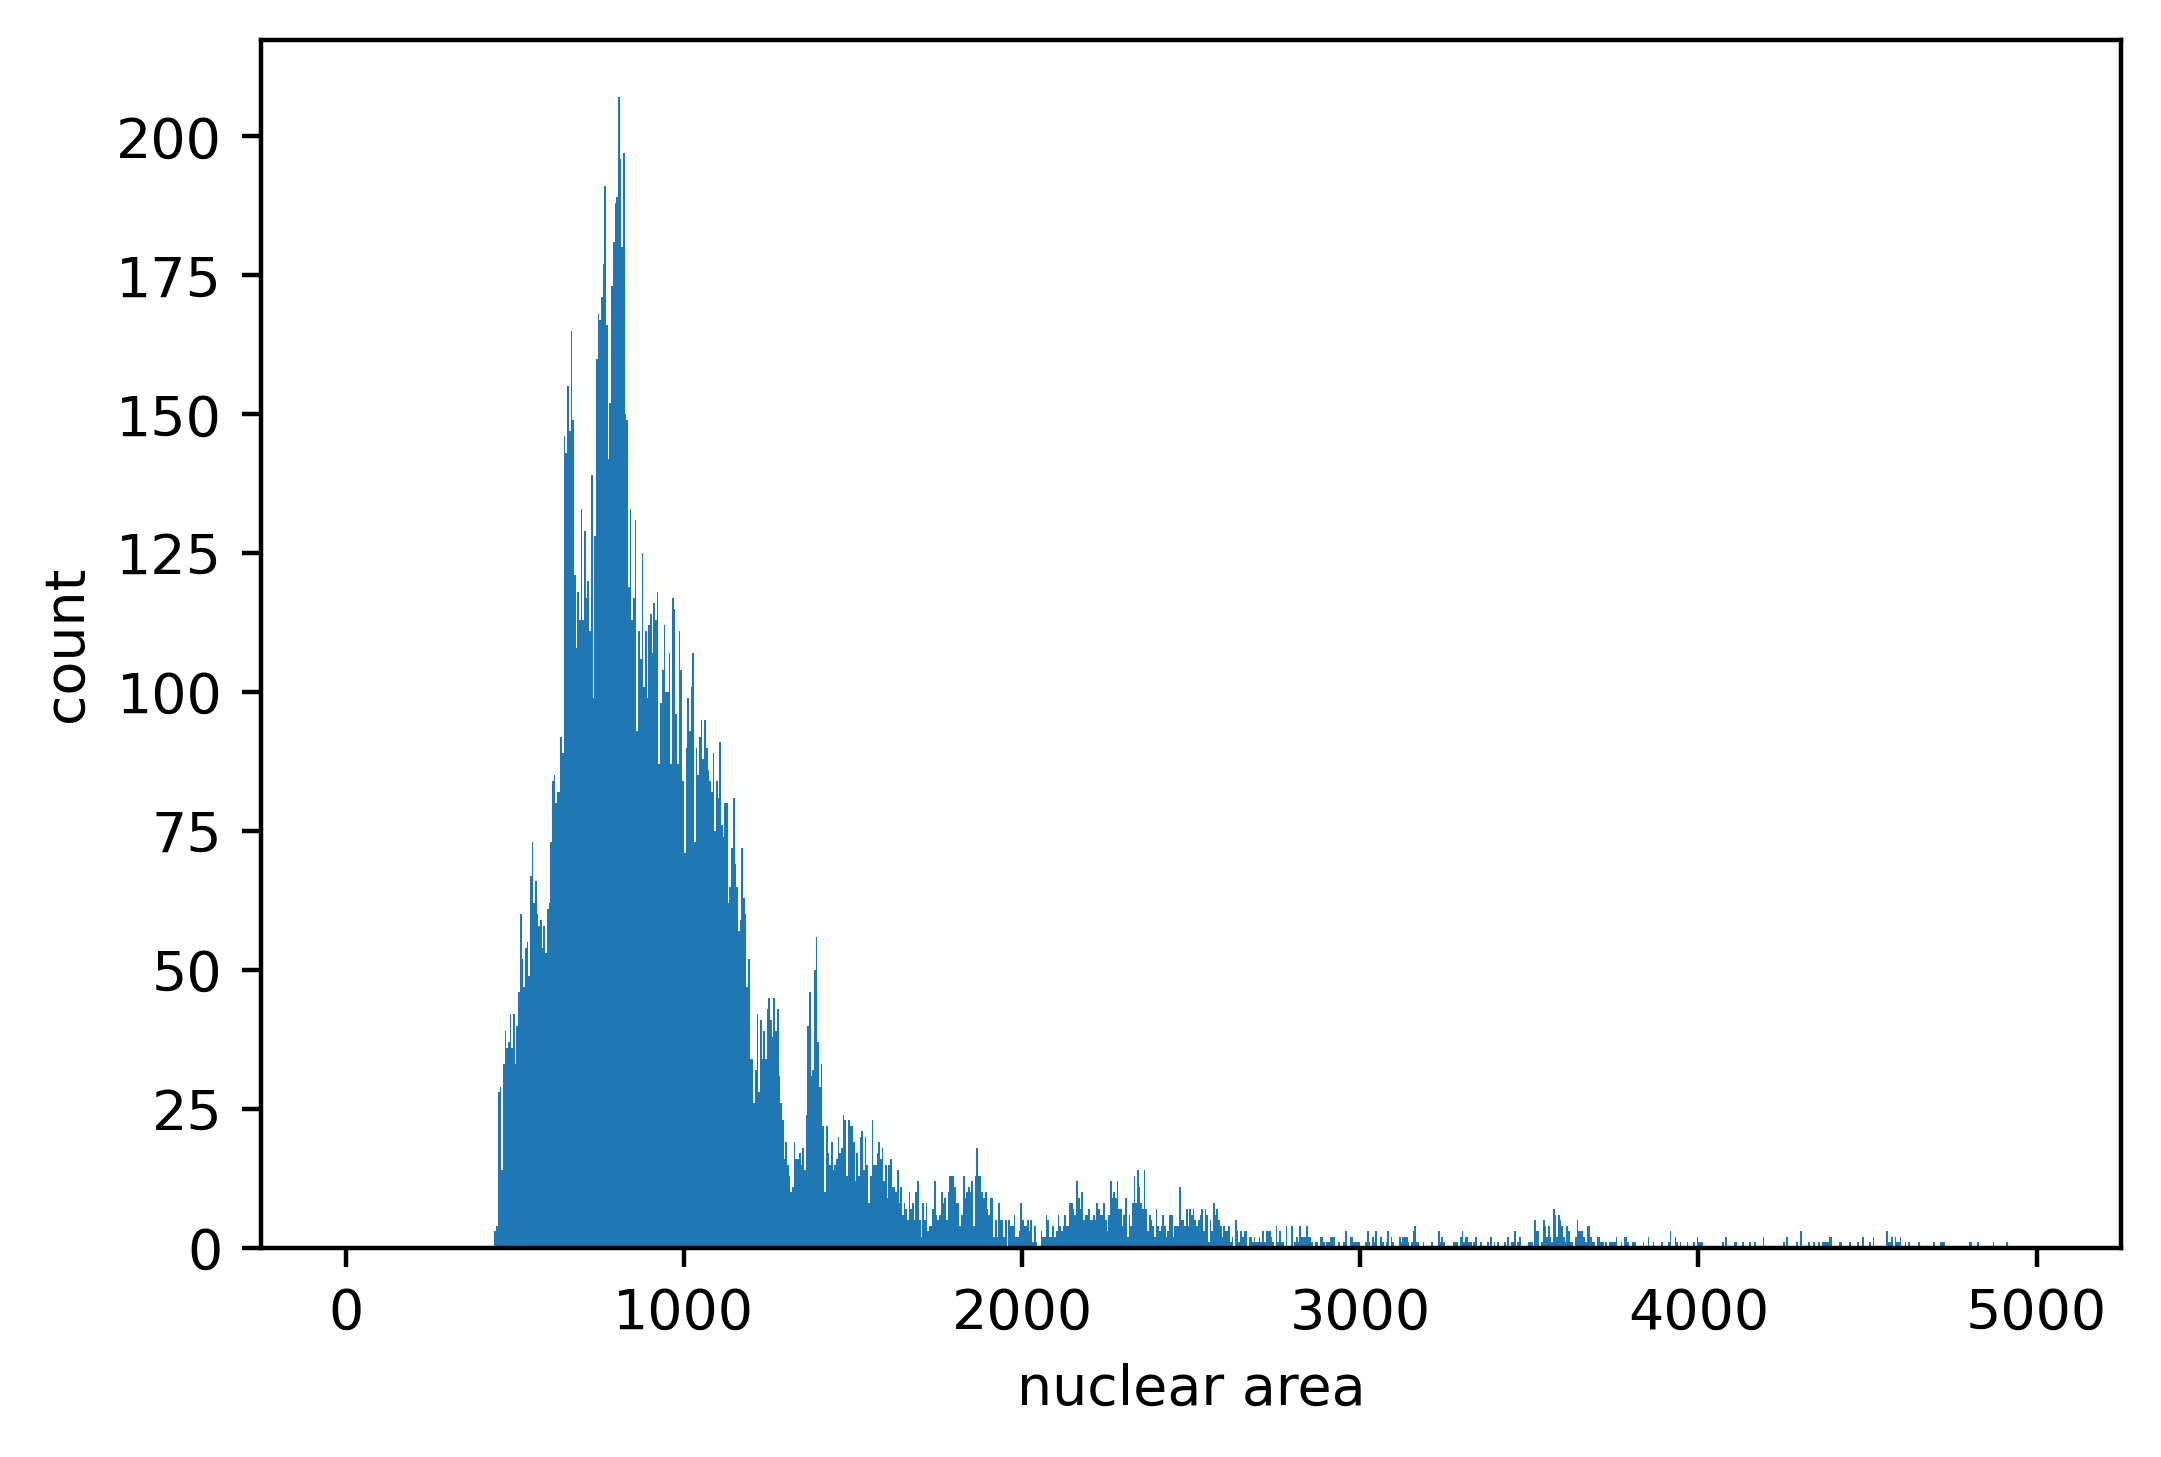

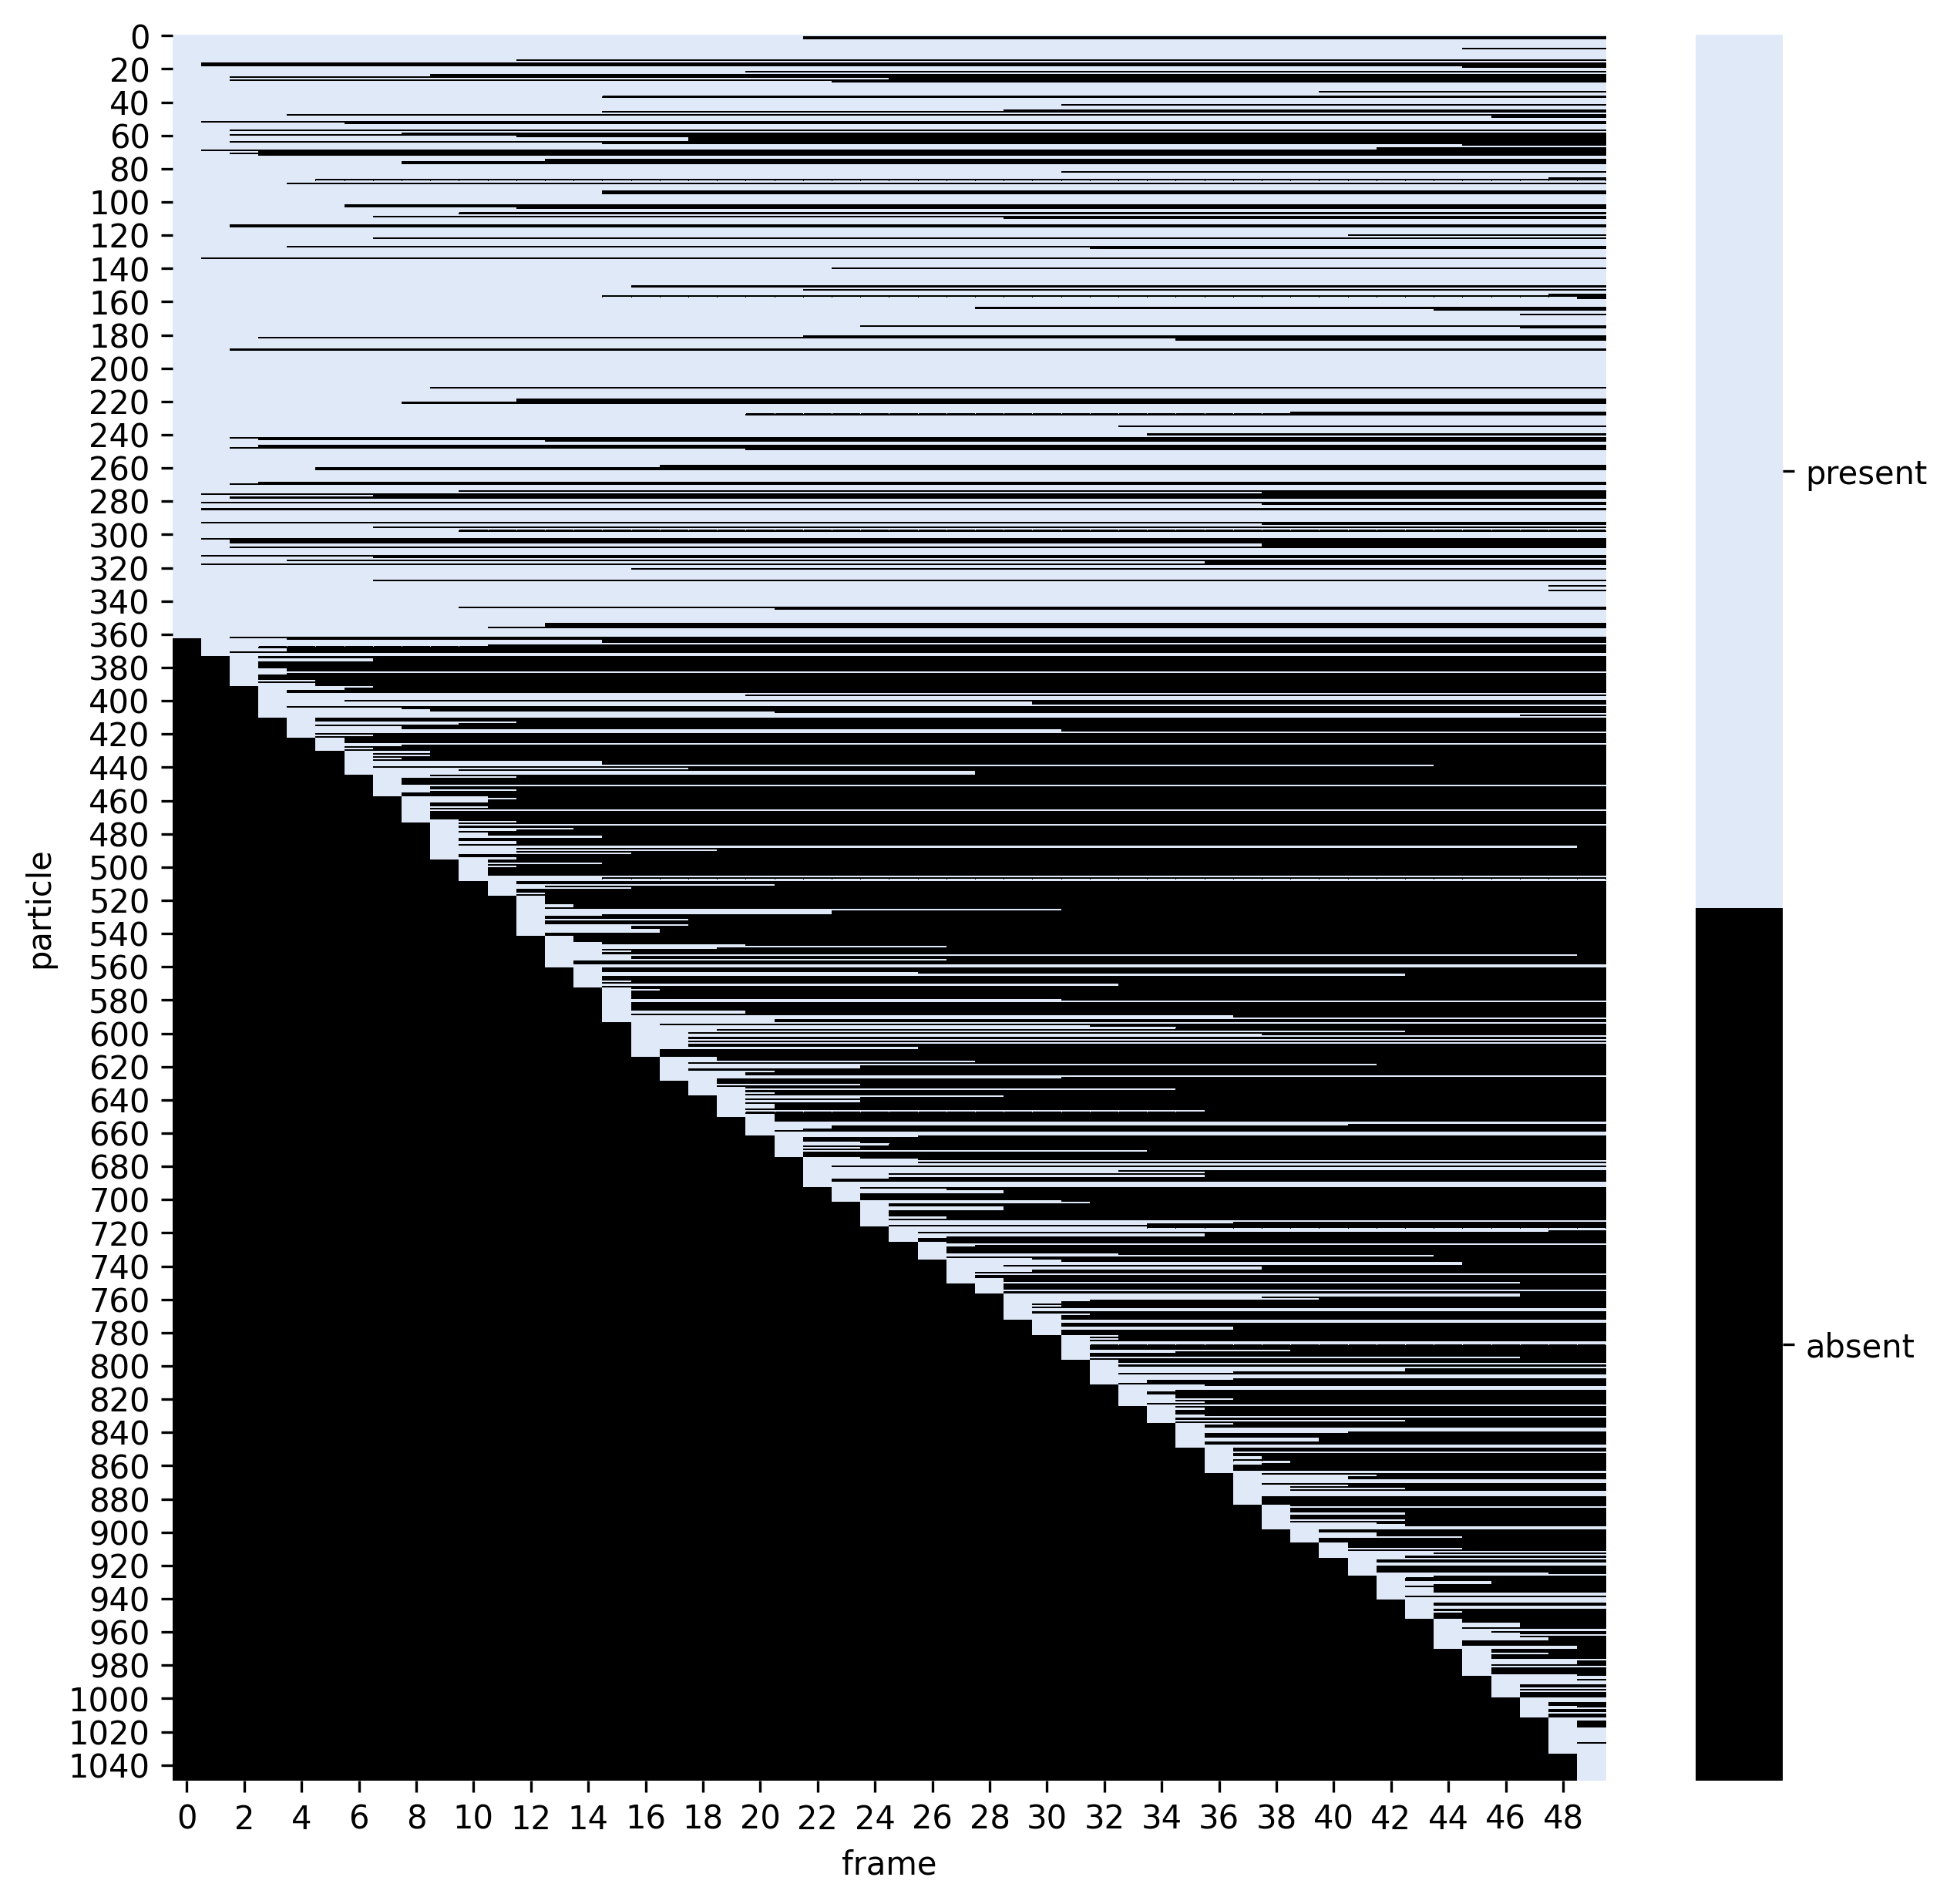

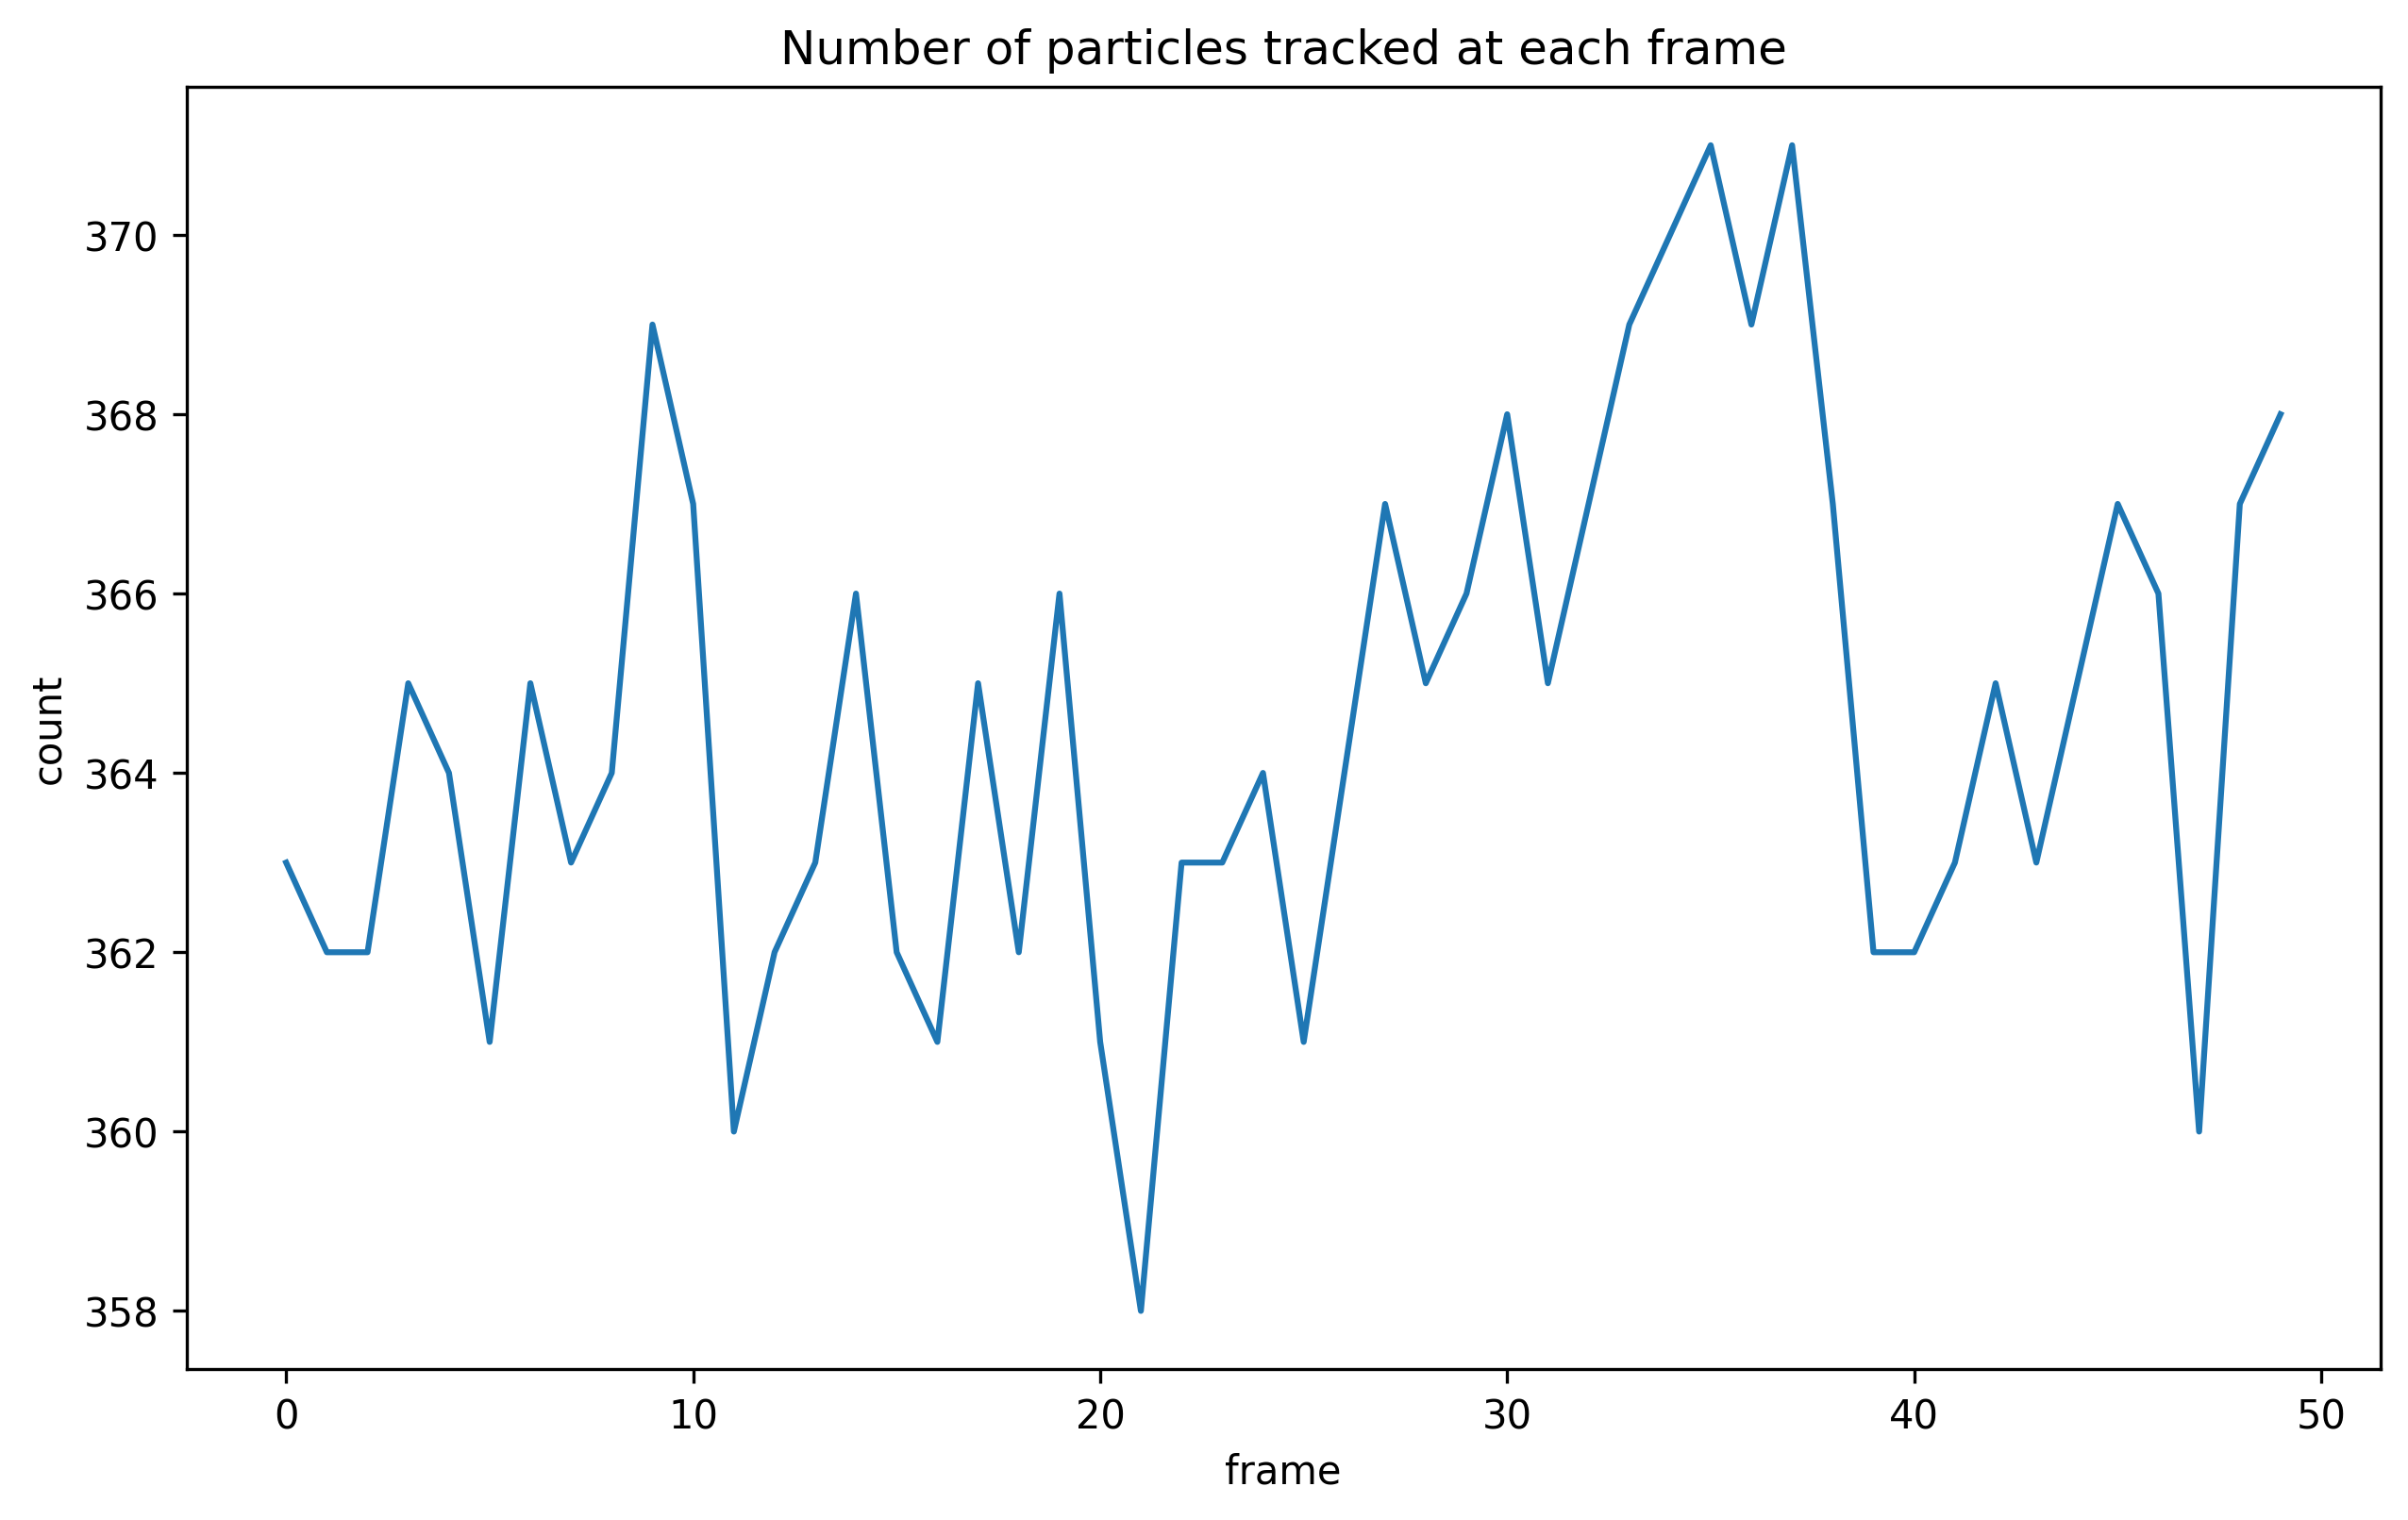

In [87]:
## PRODUCE THE PLOTS

# Original image, all 3 channels
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 6), ncols=3)
ax1.imshow(f_raw)
ax2.imshow(f_raw_c1)
ax3.imshow(f_raw_c2)
plt.show()

# Prediction probability overlay
plt.figure(figsize = (20,20))
alpha = 0.8
f_raw_scaled3 =  np.stack((f_raw_scaled,)*3, axis=-1)
prediction3 = cv2.applyColorMap(f_segmented, cv2.COLORMAP_JET)
f_raw_scaled3 = f_raw_scaled3*255
f_raw_scaled3 = f_raw_scaled3.astype('uint8')
prediction3 = prediction3.astype('uint8')
dest = cv2.addWeighted(f_raw_scaled3, alpha, prediction3, 1 - alpha,0)
plt.imshow(dest)
plt.show()


#instance segmentation overlay
plt.figure(figsize = (20,20))
label_img = label2rgb(f_labeled,image = f_raw_scaled,bg_label=0,image_alpha=1)

#ring extension segmentation overlay
plt.figure(figsize = (20,20))
label_img_rings = label2rgb(f_labeled_rings,f_raw_scaled,bg_label=0,image_alpha=1)

fig, (ax1, ax2) = plt.subplots(figsize=(20, 14), ncols=2)
ax1.imshow(label_img)
ax2.imshow(label_img_rings)
plt.show()


#trajectories of all particles and particles tracked longer than > min_nb_frames
min_nb_frames = 50
table_tracked_min_nb_frames = tp.filter_stubs(table_tracked, min_nb_frames)

fig, (ax1, ax2) = plt.subplots(figsize=(20, 10), ncols=2)
tp.plot_traj(table_tracked, ax=ax1, plotstyle= {"legend": "before filtering"})
tp.plot_traj(table_tracked_min_nb_frames, ax=ax2, plotstyle= {"legend": "after filtering"})
plt.show()


#nuclear area of all particles tracked
fig, ax = plt.subplots(figsize = (6,4),dpi = 400)
ax.hist(table_tracked['size'], bins=1000,range = (0,5000))
plt.xlabel("nuclear area")
plt.ylabel("count")
plt.show()

#presence and absence of particles
tracks=table_tracked.reset_index(drop=True)
df = tracks[["particle","frame"]]
co_mat = pd.crosstab(df.particle, df.frame)
#https://stackoverflow.com/questions/36227475/heatmap-like-plot-but-for-categorical-variables-in-seaborn
n = 2   
# discrete colormap (n samples from a given cmap)
#cmap = sns.color_palette("rocket", n) 
colors = ["#000000", "#dfe9f8"]
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize = (10,10),dpi = 300)
ax = sns.heatmap(co_mat,cmap = colors) 
# modify colorbar:
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(["absent","present"])                                          
plt.show()
sns.set_palette(sns.color_palette("tab10"))


plt.figure(figsize = (10,6),dpi = 300)
plt.title('Number of particles tracked at each frame')
co_mat.sum().plot()
plt.xlabel("frame")
plt.ylabel("count")
plt.show()